In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import livelossplot
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
import operator

Using TensorFlow backend.


# Preparing data

In [2]:
kitchenware = pickle.load(open('../../INPUT/training_dataset_all.pkl', 'rb'))
kitchenware.values.shape

(45173, 3)

In [3]:
# Prueba sin el objeto sartén

#kitchenware = kitchenware[~ (kitchenware.label == "sarten")].reset_index()

In [5]:
dummies = pd.get_dummies(kitchenware['label'])

In [6]:
dummies.head()

,cuchara,cuchillo,cuenco,hervidor,pelador,ruido,sarten,taza,tenedor,tostadora
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [7]:
dummies['gt'] = dummies.apply(lambda x: pd.Series([x.values]), axis=1)

In [8]:
dummies.head()

,cuchara,cuchillo,cuenco,hervidor,pelador,ruido,sarten,taza,tenedor,tostadora,gt
0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


# Model training

In [9]:
X = np.stack(kitchenware['image'])
y = np.stack(dummies['gt'])

In [11]:
print(X.shape)
print(y.shape)

(45173, 64, 64, 3)
(45173, 10)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [240]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(36138, 64, 64, 3)
(9035, 64, 64, 3)
(36138, 10)
(9035, 10)


In [0]:
num_classes = 10
img_rows = 64
img_cols = 64

In [242]:
# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]
# DATA NORMALIZATION
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (36138, 64, 64, 3)
36138 train samples
9035 test samples


In [243]:
model = Sequential()
chanDim = -1

if K.image_data_format() == "channels_first":
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(128)) # Probar con 28
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

# CNN params
plot_losses = livelossplot.PlotLossesKeras()

EPOCHS = 18
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

#Training the model

model.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_101 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_102 (Activation)  (None, 21, 21, 64)      

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


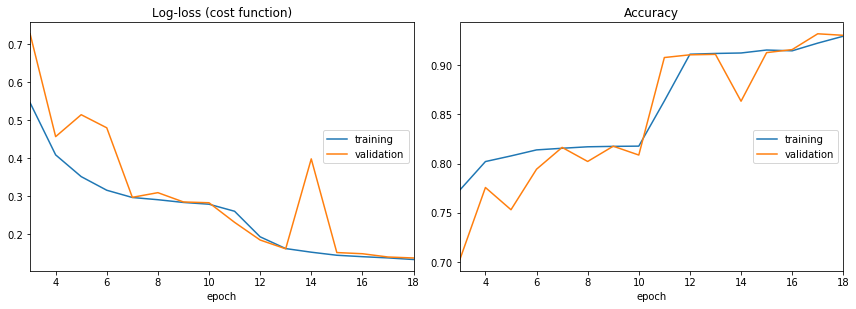

Log-loss (cost function):
training   (min:    0.134, max:    1.450, cur:    0.134)
validation (min:    0.138, max:    0.996, cur:    0.138)

Accuracy:
training   (min:    0.660, max:    0.929, cur:    0.929)
validation (min:    0.702, max:    0.932, cur:    0.930)


In [244]:
%time
model.fit(X_train, y_train,
        batch_size=BS,
        epochs=EPOCHS,
        callbacks=[plot_losses],
        verbose=1,
        validation_data=(X_test, y_test))

In [245]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13802841036695437
Test accuracy: 0.9302711676812396


In [0]:
#Modelo
model.save('bien_menos_cuchillo.h5')

In [0]:
from keras.models import load_model 
model.save('second_model.h5')

In [0]:
import json
model_json = model.to_json()
with open("second2_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("second2_model.h5")

# Checking model accuracy

In [0]:
Y_pred = model.predict(X_test)

[6 7 9 ... 9 6 0]
[6 7 9 ... 9 6 0]


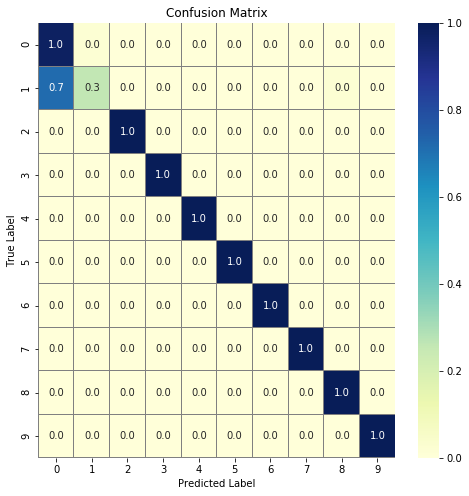

In [247]:
import matplotlib.pyplot as plt
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show();

### Cheking on test sample

In [0]:
class_names = list(dummies.columns)[:-1]

[2.2192882e-05 1.1544675e-05 9.9316591e-01 2.1292595e-05 2.0851883e-05
 2.4832292e-05 6.6848472e-03 3.0041374e-05 4.8704219e-06 1.3624738e-05]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.9900000095367432
hervidor: 0.0
pelador: 0.0
ruido: 0.0
sarten: 0.009999999776482582
taza: 0.0
tenedor: 0.0
tostadora: 0.0
(1, 64, 64, 3)


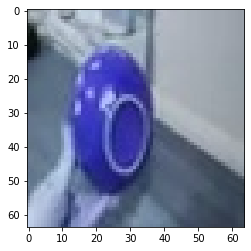

In [249]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = X_test[150]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],2)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

### Cheking on outsider sample

TEST 1:

In [250]:
import cv2
prueba1 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuchara.jpg')
print(prueba1.shape)
prueba1 = cv2.resize(prueba1,(64,64))
print(prueba1.shape)
print(type(prueba1))
print(prueba1.shape)
prueba1 = prueba1.astype('float32') / 255

(3968, 1984, 3)
(64, 64, 3)
<class 'numpy.ndarray'>
(64, 64, 3)


[5.5076075e-01 4.4315574e-01 4.0898443e-04 3.2159797e-04 1.2170193e-03
 3.3230465e-04 4.3043672e-04 4.2263212e-04 2.6294561e-03 3.2109825e-04]
cuchara: 0.550000011920929
cuchillo: 0.4399999976158142
cuenco: 0.0
hervidor: 0.0
pelador: 0.0
ruido: 0.0
sarten: 0.0
taza: 0.0
tenedor: 0.0
tostadora: 0.0
(1, 64, 64, 3)


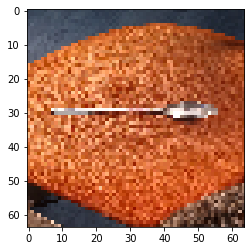

In [251]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = prueba1
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],2)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

TEST 2:

In [252]:
import cv2
prueba2 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuchillo.jpg')
print(prueba2.shape)
prueba2 = cv2.resize(prueba2,(64,64))
print(prueba2.shape)
print(type(prueba2))
print(prueba2.shape)
prueba2 = prueba2.astype('float32') / 255

(1984, 3968, 3)
(64, 64, 3)
<class 'numpy.ndarray'>
(64, 64, 3)


[0.0122208  0.00857305 0.03962401 0.00654282 0.00620246 0.10997271
 0.796303   0.00728127 0.0042136  0.00906635]
cuchara: 0.009999999776482582
cuchillo: 0.009999999776482582
cuenco: 0.03999999910593033
hervidor: 0.009999999776482582
pelador: 0.009999999776482582
ruido: 0.10999999940395355
sarten: 0.800000011920929
taza: 0.009999999776482582
tenedor: 0.0
tostadora: 0.009999999776482582
(1, 64, 64, 3)


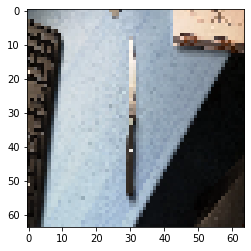

In [253]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = prueba2
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],2)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

TEST 3:

In [254]:
import cv2
prueba3 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuenco.jpg')
print(prueba3.shape)
prueba3 = cv2.resize(prueba3,(64,64))
print(prueba3.shape)
print(type(prueba3))
print(prueba3.shape)
prueba3 = prueba3.astype('float32') / 255

(1984, 3968, 3)
(64, 64, 3)
<class 'numpy.ndarray'>
(64, 64, 3)


[2.2247010e-05 1.1574511e-05 9.9314922e-01 2.1339845e-05 2.0904932e-05
 2.4887875e-05 6.7010815e-03 3.0108988e-05 4.8827897e-06 1.3657643e-05]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.9900000095367432
hervidor: 0.0
pelador: 0.0
ruido: 0.0
sarten: 0.009999999776482582
taza: 0.0
tenedor: 0.0
tostadora: 0.0
(1, 64, 64, 3)


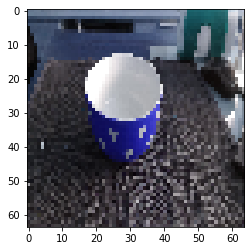

In [255]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = prueba3
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],2)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

TEST 4:

In [256]:
prueba4 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuenco2.jpg')
print(prueba4.shape)
prueba4 = cv2.resize(prueba4,(64,64))
print(prueba4.shape)
print(type(prueba4))
print(prueba4.shape)
prueba4 = prueba4.astype('float32') / 255

(1984, 3968, 3)
(64, 64, 3)
<class 'numpy.ndarray'>
(64, 64, 3)


[1.2883298e-03 6.8177731e-04 9.2884880e-01 9.0402435e-04 7.4661995e-04
 1.2474202e-03 4.2821486e-02 1.1112756e-03 2.9343524e-04 2.2056906e-02]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.9300000071525574
hervidor: 0.0
pelador: 0.0
ruido: 0.0
sarten: 0.03999999910593033
taza: 0.0
tenedor: 0.0
tostadora: 0.019999999552965164
(1, 64, 64, 3)


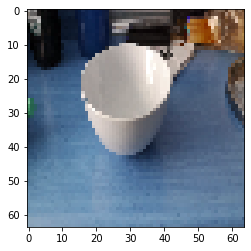

In [257]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = prueba4
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],2)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

TEST 5:

In [258]:
prueba5 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/pelador.jpg')
print(prueba5.shape)
prueba5 = cv2.resize(prueba5,(64,64))
print(prueba5.shape)
print(type(prueba5))
print(prueba5.shape)
prueba5 = prueba5.astype('float32') / 255

(1984, 3968, 3)
(64, 64, 3)
<class 'numpy.ndarray'>
(64, 64, 3)


[2.3419701e-03 1.7146920e-03 2.5363979e-03 4.8111170e-04 9.8872668e-01
 1.6917336e-03 5.6987372e-04 5.0363969e-04 7.3120563e-04 7.0275011e-04]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.0
hervidor: 0.0
pelador: 0.9900000095367432
ruido: 0.0
sarten: 0.0
taza: 0.0
tenedor: 0.0
tostadora: 0.0
(1, 64, 64, 3)


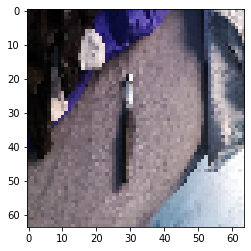

In [259]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = prueba5
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],2)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);